In [15]:
import numpy as np
import pandas as pd
from sklearn.svm import SVR
from sklearn import linear_model,metrics,svm
from sklearn.ensemble import RandomForestRegressor
from geopy.distance import vincenty,great_circle
import xgboost as xgb
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
import requests
import time
from pandas.tseries.holiday import USFederalHolidayCalendar
import lightgbm as lgb 

In [2]:
#import training and testing dataframe
train = pd.read_csv('../charlie/Desktop/NYC_Taxi/train.csv')
test = pd.read_csv('../charlie/Desktop/NYC_Taxi/test.csv')

#check the numbers of dataframe
if len(train) == 1458644:
    print 'numbers of training data :correct!'
else:
    print "numbers of training data :incorrect!"

if len(test) == 625134:
    print 'numbers of testing data :correct!'
else:
    print "numbers of testing data :incorrect!"
    
# for convinience,make them together to do futher process
df = pd.concat([train,test])
print len(df)
df.head()

numbers of training data :correct!
numbers of testing data :correct!
2083778


,dropoff_datetime,dropoff_latitude,dropoff_longitude,id,passenger_count,pickup_datetime,pickup_latitude,pickup_longitude,store_and_fwd_flag,trip_duration,vendor_id
0,2016-03-14 17:32:30,40.765602,-73.964630,id2875421,1,2016-03-14 17:24:55,40.767937,-73.982155,N,455.0,2
1,2016-06-12 00:54:38,40.731152,-73.999481,id2377394,1,2016-06-12 00:43:35,40.738564,-73.980415,N,663.0,1
2,2016-01-19 12:10:48,40.710087,-74.005333,id3858529,1,2016-01-19 11:35:24,40.763939,-73.979027,N,2124.0,2
3,2016-04-06 19:39:40,40.706718,-74.012268,id3504673,1,2016-04-06 19:32:31,40.719971,-74.010040,N,429.0,2
4,2016-03-26 13:38:10,40.782520,-73.972923,id2181028,1,2016-03-26 13:30:55,40.793209,-73.973053,N,435.0,2


In [3]:
#one-hot encoding
df.loc[df.store_and_fwd_flag == 'N','s_and_f'] = 0
df.loc[df.store_and_fwd_flag == 'Y','s_and_f'] = 1
#datetime
df['p_date'] = pd.to_datetime(df['pickup_datetime'])
df['d_date'] = pd.to_datetime(df['dropoff_datetime'])
df['weekday'] = df.p_date.dt.weekday
df.loc[df.weekday >= 5, 'is_weekend'] = 1
df.loc[df.weekday < 5, 'is_weekend'] = 0
df['p_hour'] = df.p_date.dt.hour
df.loc[(df.p_hour >=0 ) & (df.p_hour <6),'time_period'] = 1
df.loc[(df.p_hour >=6 ) & (df.p_hour <12),'time_period'] = 2
df.loc[(df.p_hour >=12 ) & (df.p_hour <18),'time_period'] = 3
df.loc[(df.p_hour >=18 ) & (df.p_hour <24),'time_period'] = 4
df['month'] = df['p_date'].dt.month
df['weekofyear'] = df['p_date'].dt.weekofyear
cal = USFederalHolidayCalendar()
holidays = cal.holidays(start='2014-01-01', end='2017-12-31').to_pydatetime()
df['Holiday'] = df['p_date'].dt.date.astype('datetime64[ns]').isin(holidays)
#distance
def D(x,y,z,w):
    return vincenty((x, y),(z, w)).miles
df['distance'] = map(D,df.pickup_latitude,df.pickup_longitude,df.dropoff_latitude,df.dropoff_longitude)

#trip_duration
df['trip_duration2'] = np.log(df.trip_duration.values)
df.head(5)

,dropoff_datetime,dropoff_latitude,dropoff_longitude,id,passenger_count,pickup_datetime,pickup_latitude,pickup_longitude,store_and_fwd_flag,trip_duration,...,d_date,weekday,is_weekend,p_hour,time_period,month,weekofyear,Holiday,distance,trip_duration2
0,2016-03-14 17:32:30,40.765602,-73.964630,id2875421,1,2016-03-14 17:24:55,40.767937,-73.982155,N,455.0,...,2016-03-14 17:32:30,0,0.0,17,3.0,3,11,False,0.933406,6.120297
1,2016-06-12 00:54:38,40.731152,-73.999481,id2377394,1,2016-06-12 00:43:35,40.738564,-73.980415,N,663.0,...,2016-06-12 00:54:38,6,1.0,0,1.0,6,23,False,1.123849,6.496775
2,2016-01-19 12:10:48,40.710087,-74.005333,id3858529,1,2016-01-19 11:35:24,40.763939,-73.979027,N,2124.0,...,2016-01-19 12:10:48,1,0.0,11,2.0,1,3,False,3.964154,7.661056
3,2016-04-06 19:39:40,40.706718,-74.012268,id3504673,1,2016-04-06 19:32:31,40.719971,-74.010040,N,429.0,...,2016-04-06 19:39:40,2,0.0,19,4.0,4,14,False,0.921886,6.061457
4,2016-03-26 13:38:10,40.782520,-73.972923,id2181028,1,2016-03-26 13:30:55,40.793209,-73.973053,N,435.0,...,2016-03-26 13:38:10,5,1.0,13,3.0,3,12,False,0.737591,6.075346


In [4]:
# use Open Street Road Map(OSRM)
#import data
fr_train1 = pd.read_csv('../charlie/Desktop/NYC_Taxi/fastest_routes_train_part_1.csv')
fr_train2 = pd.read_csv('../charlie/Desktop/NYC_Taxi/fastest_routes_train_part_2.csv')
fr_test = pd.read_csv('../charlie/Desktop/NYC_Taxi/fastest_routes_test.csv')
fr_train = pd.concat([fr_train1,fr_train2])
print len(fr_train)
fr = pd.concat([fr_train,fr_test])
print len(fr)
df = df.merge(fr, how='left', on='id')
df['speed'] = df['total_distance']/df['total_travel_time']
print len(df)

1458643
2083777
2083778


In [5]:
# coordinate:dimention reduction
coords = np.vstack((df[['pickup_latitude', 'pickup_longitude']].values,
                    df[['dropoff_latitude', 'dropoff_longitude']].values))
pca = PCA().fit(coords)
df['pickup_pca0'] = pca.transform(df[['pickup_latitude', 'pickup_longitude']])[:,0]
df['pickup_pca1'] = pca.transform(df[['pickup_latitude', 'pickup_longitude']])[:,1]
df['dropoff_pca0'] = pca.transform(df[['dropoff_latitude', 'dropoff_longitude']])[:,0]
df['dropoff_pca1'] = pca.transform(df[['dropoff_latitude', 'dropoff_longitude']])[:,1]
#clustering
#sample_ind = np.random.permutation(len(coords))[:500000]
kmeans = MiniBatchKMeans(n_clusters=100, batch_size=10000).fit(coords)
df['pickup_group'] = kmeans.predict(df[['pickup_latitude', 'pickup_longitude']])
df['dropoff_group'] = kmeans.predict(df[['dropoff_latitude', 'dropoff_longitude']])

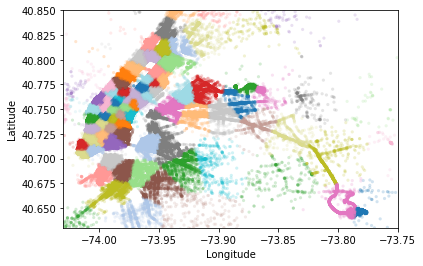

In [6]:
plt.close()
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
fig, ax = plt.subplots(ncols=1, nrows=1)
ax.scatter(df.pickup_longitude, df.pickup_latitude, s=10, lw=0,
           c=df.pickup_group, cmap='tab20', alpha=0.2)
ax.set_xlim(city_long_border)
ax.set_ylim(city_lat_border)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()
plt.close()

In [8]:
#split data into training and testing data
train = df.iloc[0:len(train)]
test = df.iloc[len(train):]
print len(train)
print len(test)

1458644
625134


In [9]:
#set xgboost parameter
var=['vendor_id','passenger_count','s_and_f','distance','weekday','is_weekend','p_hour','time_period','month','weekofyear','pickup_pca0','pickup_pca1','dropoff_pca0','dropoff_pca1','pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude','pickup_group','dropoff_group','total_distance','total_travel_time','number_of_steps','Holiday']
Xtr, Xv, ytr, yv = train_test_split(train[var].values, train['trip_duration2'], test_size=0.2, random_state=2017)
dtrain = xgb.DMatrix(Xtr, label=ytr)
dvalid = xgb.DMatrix(Xv, label=yv)
dtest = xgb.DMatrix(test[var].values)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
results ={}
# Try different parameters! My favorite is random search :)
xgb_pars = {'min_child_weight': 50, 'eta': 0.3, 'colsample_bytree': 0.3, 'max_depth': 10,
            'subsample': 0.8, 'lambda': 1., 'nthread': -1, 'booster' : 'gbtree', 'silent': 1,
            'eval_metric': 'rmse', 'objective': 'reg:linear'}

In [10]:
#run xgboost
model = xgb.train(xgb_pars, dtrain, 200, watchlist, early_stopping_rounds=100,
                  maximize=False, verbose_eval=10, evals_result=results)

[0]	train-rmse:4.22574	valid-rmse:4.22835
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 100 rounds.
[10]	train-rmse:0.424565	valid-rmse:0.432873
[20]	train-rmse:0.388754	valid-rmse:0.401352
[30]	train-rmse:0.380803	valid-rmse:0.396509
[40]	train-rmse:0.375248	valid-rmse:0.39372
[50]	train-rmse:0.372118	valid-rmse:0.39292
[60]	train-rmse:0.369404	valid-rmse:0.391897
[70]	train-rmse:0.366218	valid-rmse:0.391092
[80]	train-rmse:0.363504	valid-rmse:0.390224
[90]	train-rmse:0.361862	valid-rmse:0.389879
[100]	train-rmse:0.359428	valid-rmse:0.389289
[110]	train-rmse:0.357657	valid-rmse:0.38958
[120]	train-rmse:0.356453	valid-rmse:0.389504
[130]	train-rmse:0.355424	valid-rmse:0.389602
[140]	train-rmse:0.354324	valid-rmse:0.389789
[150]	train-rmse:0.353158	valid-rmse:0.389566
[160]	train-rmse:0.351821	valid-rmse:0.389375
[170]	train-rmse:0.351078	valid-rmse:0.389205
[180]	train-rmse:0.350185	valid-rmse:0.389

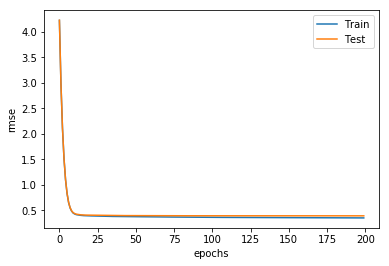

In [11]:
epochs = len(results['valid']['rmse'])
plt.close()
x_axis = range(0, epochs)
fig, ax = plt.subplots()
ax.plot(x_axis, results['train']['rmse'], label='Train')
ax.plot(x_axis, results['valid']['rmse'], label='Test')
#ax.legend()
plt.ylabel('rmse')
plt.xlabel('epochs')
plt.legend()
plt.show()
plt.close()

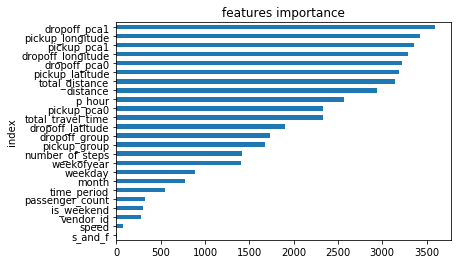

In [12]:
plt.close()
var=['vendor_id','passenger_count','s_and_f','distance','weekday','is_weekend','p_hour','time_period','month','weekofyear','pickup_pca0','pickup_pca1','dropoff_pca0','dropoff_pca1','pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude','pickup_group','dropoff_group','total_distance','total_travel_time','number_of_steps','speed','Holiday']
mapFeat = dict(zip(["f"+str(i) for i in range(len(var))],var))
fi = pd.Series(model.get_fscore())
fi.index = fi.reset_index()['index'].map(mapFeat)
fi.sort_values().plot(kind="barh", title=("features importance"))
plt.show()
plt.close()

In [13]:
ytest = model.predict(dtest)
pre = np.exp(ytest)

In [14]:
sub = pd.DataFrame({'id':test.id,'trip_duration':pre})
sub.to_csv('../charlie/Desktop/NYC_Taxi/score.csv',index=False)
print sub.describe()
print sub.head(5)

       trip_duration
count  625134.000000
mean      810.084778
std       593.390808
min         2.387684
25%       406.490089
50%       653.308807
75%      1033.044891
max      8351.274414
                id  trip_duration
1458644  id3004672     782.553162
1458645  id3505355     563.482910
1458646  id1217141     333.882172
1458647  id2150126     955.798767
1458648  id1598245     296.304230
